This document makes stimuli for printing in grayscale. Set CMYK colours later. With thanks to Dr. Jochen Smolka of [ScienceDjinn]('http://www.sciencedjinn.com/') for writing the original Matlab code for the difference of Gaussians. 

Load packages and check Python and system.

In [55]:
import numpy as np
import scipy
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # larger plots
import pandas as pd
from sklearn.linear_model import LinearRegression
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]'

Import the model object to get the ink values.

In [3]:
lm.root.3.fit = readRDS('reflectance.fit.rds')

SyntaxError: invalid syntax (<ipython-input-3-90ef01e51cd5>, line 1)

In [87]:
reflec_df = pd.read_csv('material_reflectance.csv')
reflec_df.describe()

,Unnamed: 0,dark,white,reflectance
count,20.00000,20.000000,20.000000,20.000000
mean,10.50000,47.750000,0.522500,0.242284
std,5.91608,30.020826,0.300208,0.307289
min,1.00000,0.000000,0.000000,0.000000
25%,5.75000,23.750000,0.287500,0.004430
50%,10.50000,47.500000,0.525000,0.102561
75%,15.25000,71.250000,0.762500,0.380564
max,20.00000,100.000000,1.000000,1.000000


In [ ]:
coef = np.polyfit(reflec_df.dark,reflec_df.reflectance,1)
poly1d_fn = np.poly1d(coef)
# poly1d_fn is now a function which takes in x and returns an estimate for y

In [ ]:
reg = LinearRegression().fit(reflec_df.dark,reflec_df.reflectance)
reg.score(reflec_df.dark,reflec_df.reflectance)
reg.coef_array([1., 2.])
reg.intercept
reg.predict(np.array([[3, 5]]))
array([16.])

#### Define the pattern height (h_pattern) and width (w_pattern) in mm.

For pixartprinting.it, save to PDF high quality and color as Fogra39. Keep sides
below 5m and leave 1 mm extra at each side. 

The arena as an internal diameter of 93cm, making 92cm a reasonable diameter for
the pattern.

The image below represents the pattern when the reflectances are translated into overall ink values but before finding the value of each of CMYK according to fogra39.

Check if can change the colour profile in Adobe with Edit > Convert to Profile. If so, just use k values exported to a tiff.

In [4]:
w_pattern   = np.ceil(920*np.pi)
h_pattern   = 500
print("The pattern is",w_pattern/10,"cm in width")

The pattern is 289.1 cm in width


In [6]:
cw             = "Mex"  # pick the continuous wavelet to use: "DoG", "Mex" or "Sine"
print_img      = True   # should this markdown print the pattern image
check_tif      = True   # reload image back into R
T              = 100    # period in degrees
Michelson      = 1      # Michelson contrast in pattern
blacklevel     = round(np.sqrt(1 - Michelson),3) # reduce contrast by whitening the black
dpi            = 150 #resolution (dots per inch)  100-150 dpi for pixartprinting.it 
w_pattern_px   = int(round(dpi * w_pattern / 25.4)) # pixels required along x
h_pattern_px   = int(round(dpi * h_pattern / 25.4)) # pixels required along y
T_px           = (T/360)*w_pattern_px
tifname        = cw+'_'+str(T)+'_'+str(dpi)+'dpi.tiff'    # filename for the output tiff
print ('Filename:'+tifname)

Filename:Mex_100_150dpi.tiff


#### Sine wave

Have actually used a cosine to move the optimum to the centre.

In [7]:
h1    = lambda x: np.cos(x*2*np.pi/T_px); # factor the equation by some amplitude
x_px  = np.linspace( int(0.5-w_pattern_px/2), int(-0.5+w_pattern_px/2), w_pattern_px )

Plot the sin f(x)

Text(0, 0.5, 'y')

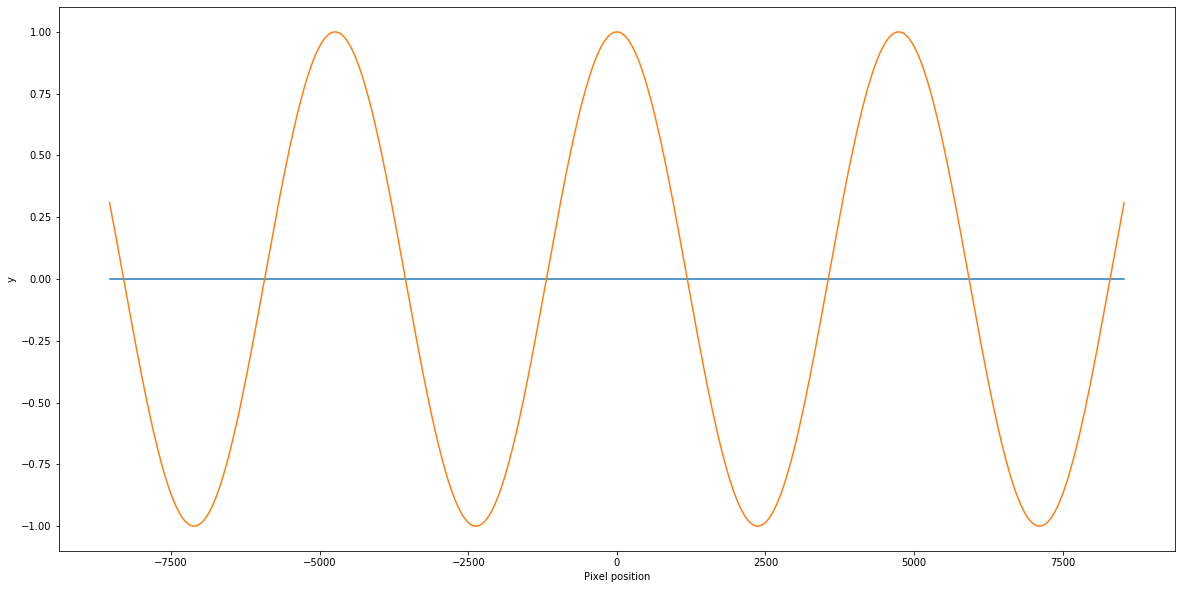

In [18]:
x1, y1 = [-w_pattern_px/2, w_pattern_px/2], [0, 0] # add zero line
plt.plot(x1, y1, marker = '')
plt.plot(x_px, h1(x_px))
plt.xlabel('Pixel position')
plt.ylabel('y')

#     axis(1, seq(from=-w_pattern_px/2,to=w_pattern_px/2,length.out = 13),
#             seq(from=-180,to=180,length.out = 13)  )

#### DoG
The half-width of the secondary (white) Gaussian is equivalent to the period of the wavelet (T_px). The half-width of the primary (black) Gaussian (fwhm1) is half the period width.

In [9]:
fwhm1   =    T_px/2 # half-width of primary (black) Gaussian is half period width (half-width of secondary Gaussian)
sigma1  =    fwhm1/ (2*np.sqrt(2*np.log(2)))   # sigma of primary Gaussian
sigma2  =    T_px / (2*np.sqrt(2*np.log(2)))   # sigma of secondary Gaussian
g1      =    lambda x: 1   * np.exp(-x**2/(2*sigma1**2))
g2      =    lambda x: -.5 * np.exp(-x**2/(2*sigma2**2)) 
aDoG    =    lambda x: g1(x) + g2(x)    # unnormalized DoG with unmax contrast

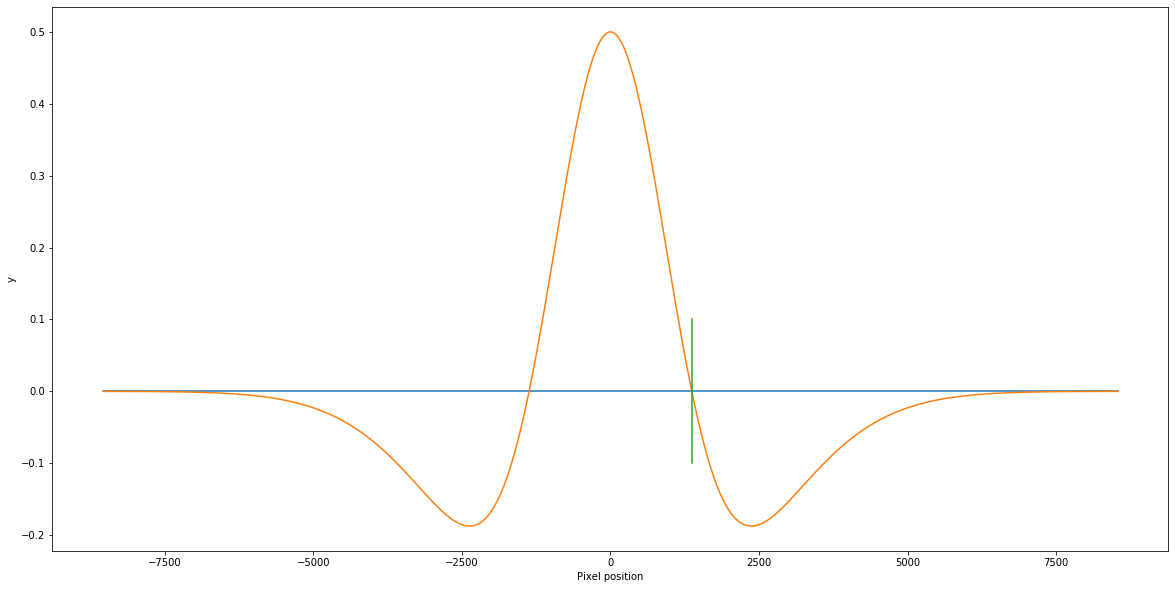

In [14]:
x1, y1 = [-w_pattern_px/2, w_pattern_px/2], [0, 0] # add zero line
plt.plot(x1, y1, marker = '')
plt.plot(x_px, aDoG(x_px))
plt.xlabel('Pixel position')
plt.ylabel('y')

x1, y1 = [.5*T_px/np.sqrt(3), .5*T_px/np.sqrt(3)], [-.1, .1]
plt.plot(x1, y1, marker = '')

#     axis(1, seq(from=-w_pattern_px/2,to=w_pattern_px/2,length.out = 13),
#             seq(from=-180,to=180,length.out = 13)  )

In [ ]:
#lines(x=c(fwhm1/2,fwhm1/2),y=c(0,.5), col="black",lwd="2")
#lines(x=c(T_px/2,T_px/2),y=c(-.25,0), col="orange",lwd="2")
#lines(x=c(.5*fwhm1/1.418,.5*fwhm1/1.418),y=c(0,.25),col="blue",lwd="2") #half-width of DoG (dark target)
#lines(x=c(.5*T_px/sqrt(3),.5*T_px/sqrt(3)),y=c(-.2,.2), col="grey",lwd="2") #zero-crossing
#lines(x=x_px,y=g1(x_px), col="black")
#lines(x=x_px,y=g1(x_px), col="black")
#lines(x=x_px,y=g2(x_px), col="orange")

The primary and secondary Gaussians are black and orange respectively; the resultant DoG is blue. Vertical lines from the x-axis demarcate the half maximum of the right side of each function. The half-width (fwhm) of the secondary Gaussian equals the distance between the minima of the DoG, which is the wavelet *period* (T). The zero-mean crossing (grey) width is a $1/\sqrt 3$ factor of the wavelet period.

#### Ricker Wavelet / Mexican Hat

The portion of the wavelet below the x-axis is 31% of the range. 

In [20]:
#A   = 2/(sqrt(3*w_pattern_px)*(pi**0.25))   # Scaling part for Mexican hat, which I have ignored
B    =  np.sqrt(3)*2*(360/T)
Mh   =  lambda x:(1-((B)*(x/w_pattern_px))**2)*np.exp(-0.5*((B)*(x/w_pattern_px))**2)

Plot the Mexican hat:

Text(0, 0.5, 'y')

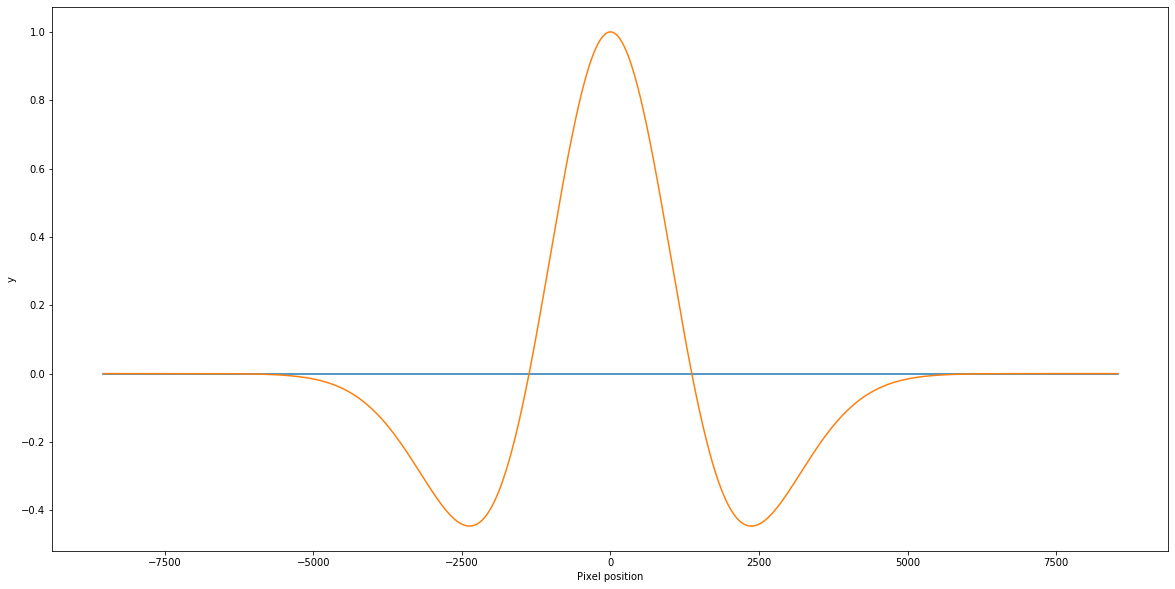

In [21]:
x1, y1 = [-w_pattern_px/2, w_pattern_px/2], [0, 0] # add zero line
plt.plot(x1, y1, marker = '')
plt.plot(x_px, Mh(x_px))
plt.xlabel('Pixel position')
plt.ylabel('y')

#plot(1, type="n", xlab="", ylab="", 
#     xlim=c(0.5-w_pattern_px/2, -0.5+w_pattern_px/2), ylim=c(-.5, 1), xaxt='n')
#     axis(1, seq(from=-w_pattern_px/2,to=w_pattern_px/2,length.out = 13),
#             seq(from=-180,to=180,length.out = 13)  )
#abline(a=0,b=0,col="grey")
#lines(x=x_px,y=Mh(x_px), col="orange",lwd=1)
#lines(x=c(.5*T_px/sqrt(3),.5*T_px/sqrt(3)),y=c(-.2,.2)) # mark zero mean
#lines(x=c(.5*T_px/exp(1),.5*T_px/exp(1)),y=c(0,.5))    # mark target half-width

Above is a Mexican hat function - a special case of the Laplacian of Gaussians. The zero-mean crossing of the dark target is $1/\sqrt 3$ of the period (T). The half-width of the dark target is $T/e^1$, which is 0.637 of the zero-crossing.  

#### Maximize contrast and plot continuous wavelets

Here we modify the wavelet functions to fit the 0-1 scale. 

In [22]:
DoG   = lambda x: 1.454547 * (g1(x) + g2(x)) + 0.2727263  #Maximize contrast
Mex   = lambda x: (Mh(x) + 0.4462601)/1.4462601    #Maximize contrast
Sine  = lambda x: 1 * (h1(x)+1)/2    # factor this according to the black level

Plot them together:

In [26]:
#axis(1, seq(from=-w_pattern_px/2,to=w_pattern_px/2,length.out = 13),
#             seq(from=-180,to=180,length.out = 13)  )
#abline(a=0.2727263,b=0,  col="lightblue",lwd=2,lty=2)
#abline(a=0.3085614,b=0,  col="pink",lwd=2,lty=2)
#legend("topright",c("DoG","Mexican hat","Sine"),fill=c("blue","red","grey"),bty="n")

Text(0, 0.5, 'Normalized intensity')

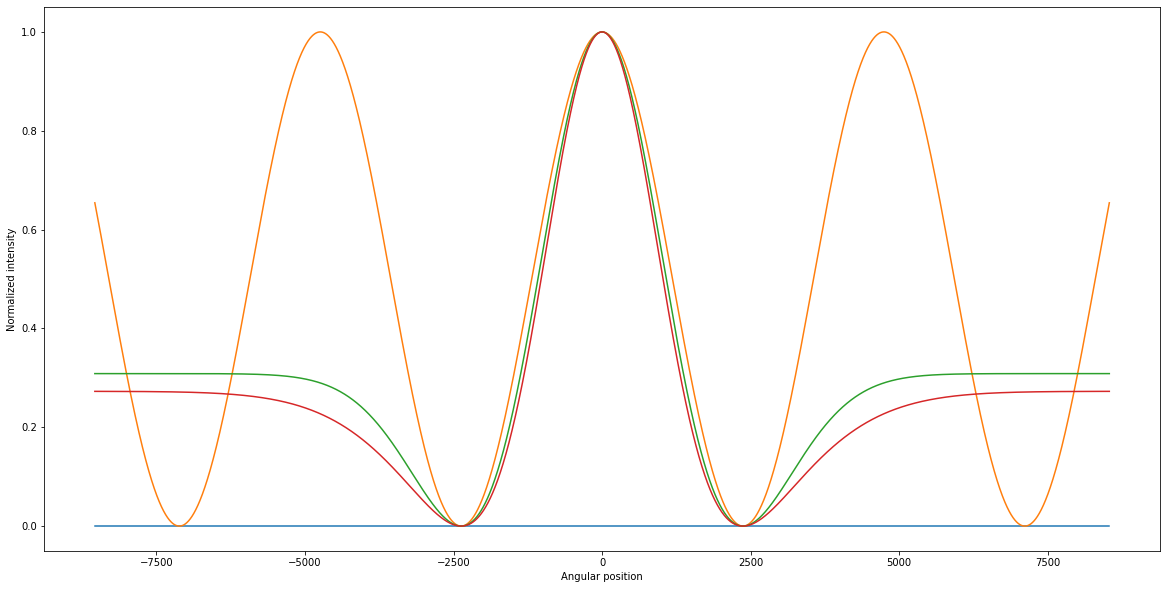

In [29]:
x1, y1 = [-w_pattern_px/2, w_pattern_px/2], [0, 0] # add zero line
plt.plot(x1, y1, marker = '')
plt.plot(x_px, Sine(x_px))
plt.plot(x_px, Mex(x_px))
plt.plot(x_px, DoG(x_px))
plt.xlabel('Angular position')
plt.ylabel('Normalized intensity')
#Axes.text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#### Modulation tranfer function
We can also Fourier transform them

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

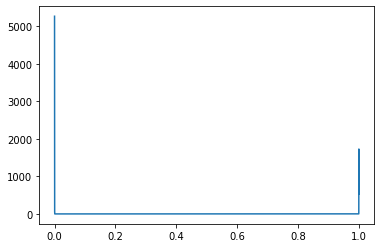

In [78]:
for i in [Mex, Sine, DoG]:
    #X=fftshift(fft(i(x_px),w_pattern_px)) #compute DFT using FFT
    X=fft(i(x_px),w_pattern_px) #compute DFT using FFT
    #fVals=np.arange(start = -w_pattern_px/2,stop = w_pattern_px/2)/w_pattern_px #DFT Sample points   
    fVals=np.arange(start = 0,stop = w_pattern_px)/w_pattern_px #DFT Sample points        
    plt.plot(fVals,np.abs(X))
    #plt.set_title('Double Sided FFT - without FFTShift')
    #plt.set_xlabel('Spatial frequency')
    #plt.set_ylabel('DFT Values')
    ##plt.set_xticks(np.arange(-0.5, 0.5+0.1,0.1))
#fig1.show()


The blue line is the DoG and the red is the similar Mexican hat.

#### Maximize the contrast in the printed pattern

In the test pieces, we used fogra39 rich black (defined below) to produce as dark a black as possible. The other shades were defined as proportions of the ink used for black. On measurement, we found that the inks were defined by a cubic root relationship, whereby the darkest shades were extremmely similar to one another. The darkest black was not perfectly absorbing but reflected 4% of the light (for a pattern at 5 cm distance in air). We expect slightly less reflectance in the experimental setup in water than the short distance . 

#### Create image

Define pixel number along x (w_pattern_px) and y (h_pattern_px) axes.

In [60]:
def max_pattern_contrast(input_vec , total_y):
    v0 = input_vec-min(input_vec);
    output_vec = (v0/max(v0))*total_y;
    return (output_vec)

In [63]:
if(cw == "DoG"):
    singleline = max_pattern_contrast(DoG(x_px), 1) 
elif(cw == "Mex"):
    singleline = max_pattern_contrast(Mex(x_px), 1)
elif(cw == "Sine"):
    singleline = max_pattern_contrast(Sine(x_px), 1)

Calculate a single line of the image and normalize to max contrast. We plot it below.

In [ ]:
img = as.raster(rep.row(singleline, h_pattern_px))
implot = as.cimg(t(-signif(rep.row(singleline, h_pattern_px),8)))
        plot(implot, xlab="Horizontal",ylab="Vertical", asp= 1, 
        main="Approximation of printed pattern")

In [ ]:
image_browse(image_read(img))

#### Michelson contrast

Several measures of contrast exist. Michelson contrast is convenient when the stimulus is a non-negligible contributor to the overall luminance, as here. Contrast is reduced by increasing the luminance of the darkest areas. *Modulation* is a formulation of Michelson contrast for signals to show how much they stand out from the background.

In [ ]:
print(paste('The Michelson contrast is:',
(max(singleline) - min(singleline))/(max(singleline) + min(singleline))
))

**Make version with both black and white receding.**

#### Root mean square contrast

RMS is the same over one line or many identical ones. It computes variation across all pixels and does not depend on the angular frequency or spatial distribution of contrast.

In [69]:
RMS = np.round(np.sqrt((1/len(singleline))*sum(singleline**2)),8)
print ('The RMS contrast is '+str(np.round(RMS,3)))

The RMS contrast is 0.382


#### Modify shades to correspond to reflectance 

The ink shades above 90% rich black were barely distinguishable and the curve peaks at 93.5. Although the difference is small, we maximize the blackness of the black region by bringing the values above 85 (1% of pixels) to 100.

In [81]:
def get_ink_done(model_fit,reflectance_vector):
    temp_df        = pd.dataframe(reflectance_vector)
    temp_df.name   = 'reflectance'
    inkz           = np.round(predict(lm.root.3.fit,newdata=temp_df),8)
    print str(round(len(inkz[inkz < 0])*100/len(inkz),1)))+"% values were below 0, i.e. brighter than white"
    inkz[inkz < 0]  = 0   # remove impossible values
    inkz[inkz > 85] = 100 # maximize the very darkest values
    print "Number pixels on x axis at darkest:"+str(length(inkz[inkz > 90])))
    return(inkz)

inkline = get_ink_done(lm.root.3.fit, singleline)

SyntaxError: invalid syntax (<ipython-input-81-7b7da4d282b0>, line 4)

And get the value at quantiles of reflectance:

In [111]:
temp_df         = pd.dataframe( np.linspace(0,1,11) )
names(temp_df)  = 'reflectance'
np.round(predict(lm.root.3.fit,newdata=temp_df),5)

SyntaxError: invalid syntax (<ipython-input-111-cb4e691ae4de>, line 3)

The following plot shows the relationship between reflectance and the ink value encapsulated in the fit. 

In [ ]:
plot(NULL,xlim=c(0,w_pattern_px),ylim=c(0,100),
     ylab ="Ink value / Reflectance",xlab="Angular position",xaxt="n")
axis(1, seq(from=0,to=w_pattern_px,length.out = 13),
             seq(from=-180,to=180,length.out = 13)  )
abline(a=0,b=0,col="magenta")
lines(singleline*100,col="red",lty=2)           # reflectance
lines(inkline,col="blue")  

Remember that the miminum values are normalized: The lowest reflectance measured was 4%. This value was measured at 5 cm in air - the reflectance of the dark pattern will be lower in the arena (46 cm away in water, leading to some attenuation) but appreciable. 

#### Plot the 1 channel image

The plot below is just of the k channel (inverted) pre Fogra39. We take the inverse of the image so that increasing values are darker, and the transpose is taken to make it horizontal. 

In [109]:
rep.row  =  lambda x,n: np.array(rep(x,each=n), c(n,len(x)))
if  (check_tif == "True"):
     plot((t(-signif(rep.row(inkline, h_pattern_px),8))),
     xlab="Horizontal",ylab="Vertical", asp= 1,
     main="Approximation of printed pattern")
elif implot = (t(-signif(rep.row(inkline, h_pattern_px),8)))
     plot(implot, xlab="Horizontal",ylab="Vertical", asp= 1, 
     main="Approximation of printed pattern")

SyntaxError: invalid syntax (<ipython-input-109-f8521f9d5cbb>, line 6)

Below, we print the image to a tiff.

In [ ]:
if (print_img == "True"){
writeTIFF(1-(rep.row(inkline, h_pattern_px)/100),tifname,
          bits.per.sample = 8L)
print('Image printed to tiff')
} else {print('No image made as print_img set to FALSE')}

#### Check printed image

This checks the printed image by loading it back into R with *magick*. You will need ImageMagick ('https://imagemagick.org/script/download.php').

In [ ]:
if (check_tif=="True"){
image_read(tifname) %>% plot() }

### CMYK graph

Modifiy this to plot all 4 lines in their respective colours. We don't work with 
CMYK values in R but they will eventually be printed as such. I have found it simplest to set the colors in Adobe Illustrator. Make a global color swatch with the rich black (e.g. Fogra39), select the object and double-click the swatch.

In [ ]:
fogra39_richblack = c(91, 79, 62, 97) # col vec for matrix multiplication
cmyk_lines             = signif(inkline %*% t(fogra39_richblack)/100,8)
colnames(cmyk_lines)   = c("C","M","Y","K")
cmyk_lines             = as_tibble(cmyk_lines)
cmyk_lines             = melt(cmyk_lines, id.vars=1:length(cmyk_lines))
cmyk_lines %>% mutate(xpos = ( (360*(row_number()-1))/(dim(cmyk_lines)[1]-1))-180) -> cmyk_lines

Has been modified so that cmyk_lines$xpos runs -180 to +180 exactly.

In [ ]:
cmyk_lines %>%
  ggplot(aes(x=xpos,y=K)) + geom_line(color="black",linetype=3,size=1.1) + 
  geom_hline(aes(yintercept=0),linetype=3) +
  geom_line(aes(x=xpos,y=C,color="cyan"),linetype=3,size=1.1) + 
  geom_line(aes(x=xpos,y=Y,color="yellow"),linetype=3,size=1.1) + 
  geom_line(aes(x=xpos,y=M,color="magenta"),linetype=3,size=1.1) + 
  geom_line(aes(y=singleline*100),colour="grey") +
  theme_classic() + xlab('Angular position') + ylab('Ink') + theme(legend.position = "")